# COMP3010 Machine Learning Assignment
By Daehwan Yeo
- Kaggle Team Name: 19448288
- Leaderboard Score: 0.19389

# 0.0 Setting Up the Environment

In [49]:
# Mount the assignment dataset
!curl -LJO https://raw.githubusercontent.com/qilinli/COMP3010-Machine-Learning/refs/heads/master/2025-assignment/train.csv
!curl -LJO https://raw.githubusercontent.com/qilinli/COMP3010-Machine-Learning/refs/heads/master/2025-assignment/test.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1186k  100 1186k    0     0  3744k      0 --:--:-- --:--:-- --:--:-- 3754k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  328k  100  328k    0     0  1057k      0 --:--:-- --:--:-- --:--:-- 1060k


In [50]:
# Install and import necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras optuna --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import optuna
import warnings

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [51]:
# Load datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 1.0 Basic Understanding & Plotting Diagrams
To gain a better understanding of the situation, I decided to explore the dataset.

In [52]:
# Basic Exploration
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Overview of data types and non-null values
train.info()

# Basic statistics of numerical columns
train.describe(include='all')

Train shape: (10050, 25)
Test shape: (3203, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10043 non-null  float64
 1   Tank Failure Pressure (bar)      10040 non-null  float64
 2   Liquid Ratio                     10041 non-null  float64
 3   Tank Width (m)                   10043 non-null  float64
 4   Tank Length (m)                  10045 non-null  float64
 5   Tank Height (m)                  10042 non-null  float64
 6   BLEVE Height (m)                 10040 non-null  float64
 7   Vapour Height (m)                10041 non-null  float64
 8   Vapour Temperature (K)           10022 non-null  float64
 9   Liquid Temperature (K)           10022 non-null  float64
 10  Obstacle Distance to BLEVE (m)   10042 non-null  float64
 11  Obstacle Width (m)              

,Unnamed: 0,Tank Failure Pressure (bar),Liquid Ratio,Tank Width (m),Tank Length (m),Tank Height (m),BLEVE Height (m),Vapour Height (m),Vapour Temperature (K),Liquid Temperature (K),...,Status,Liquid Critical Pressure (bar),Liquid Boiling Temperature (K),Liquid Critical Temperature (K),Sensor ID,Sensor Position Side,Sensor Position x,Sensor Position y,Sensor Position z,Target Pressure (bar)
count,10043.000000,10040.000000,10041.000000,10043.000000,10045.000000,10042.000000,10040.000000,10041.000000,10022.000000,10022.000000,...,10042,10022.000000,10023.000000,10021.000000,10042.000000,10040.000000,10043.000000,10041.000000,10043.000000,10044.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Subcooled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8202.264363,37.983131,0.494445,1.726197,5.525386,1.641390,1.028982,0.855979,398.850036,343.708088,...,NaN,40.012273,-19.837174,126.576679,14.007469,2.334960,12.945712,2.910915,3.105118,0.361770
std,2886.578512,233.864180,0.227213,0.763225,2.631281,0.728311,0.572448,0.537254,71.504617,36.609621,...,NaN,2.292440,20.433469,27.561571,7.791977,1.334432,4.164641,4.638664,4.263664,0.505487
min,3203.000000,4.890000,0.100000,0.380000,0.580000,0.380000,-0.020000,0.180000,281.130000,282.540000,...,NaN,37.900000,-42.000000,96.700000,1.000000,1.000000,5.150000,-9.050000,-2.900000,0.016098
25%,5703.500000,13.177500,0.280000,1.010000,3.210000,1.010000,0.590000,0.410000,341.940000,312.580000,...,NaN,37.900000,-42.000000,96.700000,7.000000,1.000000,9.350000,-0.150000,-0.600000,0.102128
50%,8204.000000,21.375000,0.510000,1.790000,5.410000,1.600000,1.010000,0.780000,389.165000,342.320000,...,NaN,37.900000,-1.000000,152.000000,14.000000,2.000000,12.750000,2.700000,2.300000,0.203185
75%,10701.500000,32.822500,0.680000,2.400000,7.820000,2.210000,1.590000,1.210000,445.000000,367.990000,...,NaN,42.500000,-1.000000,152.000000,21.000000,3.000000,16.250000,6.150000,5.500000,0.413152


There are 25 features in the dataset. Plotting some diagrams would give us a better understanding of their relationships and help us decide which features to use and which to drop.

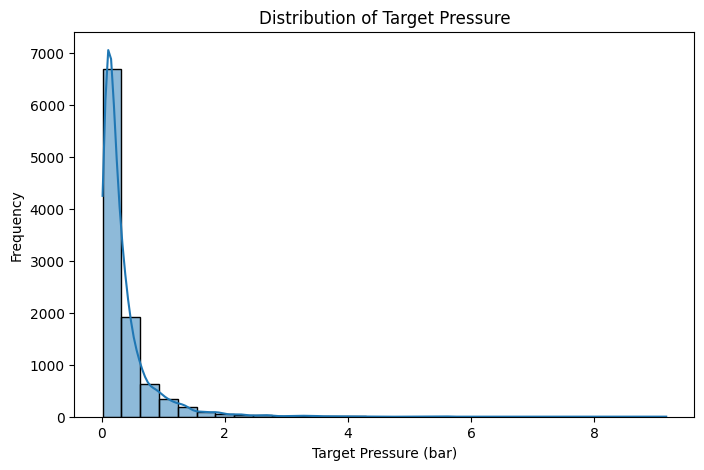

In [53]:
# Plotting the distribution of the target variable 'Target Pressure (bar)'

plt.figure(figsize=(8,5))
sns.histplot(train["Target Pressure (bar)"], kde=True, bins=30)
plt.title("Distribution of Target Pressure")
plt.xlabel("Target Pressure (bar)")
plt.ylabel("Frequency")
plt.show()

It helps us understand the spread and shape of the target values.
The KDE (Kernel Density Estimate) overlay provides a smooth approximation of the distribution.
Important for knowing if the target is skewed, which can affect model performance.

If the target variable is normally distributed, it's good for linear regression
If it's skewed, it may suggest robust models like XGBoost, neural networks.

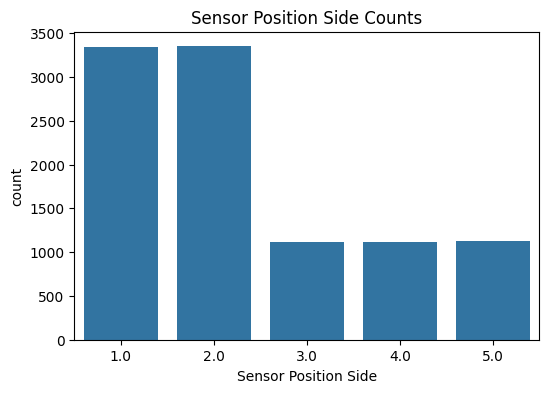

In [54]:
# Sensor Position Side frequency
plt.figure(figsize=(6,4))
sns.countplot(x='Sensor Position Side', data=train)
plt.title("Sensor Position Side Counts")
plt.show()

Visualizing the frequency of each category in the 'Sensor Position Side' feature.
Important for understanding the distribution of this categorical feature.
Understand how balanced the categorical feature is.
If very imbalanced, models might need careful handling such as weighting classes.

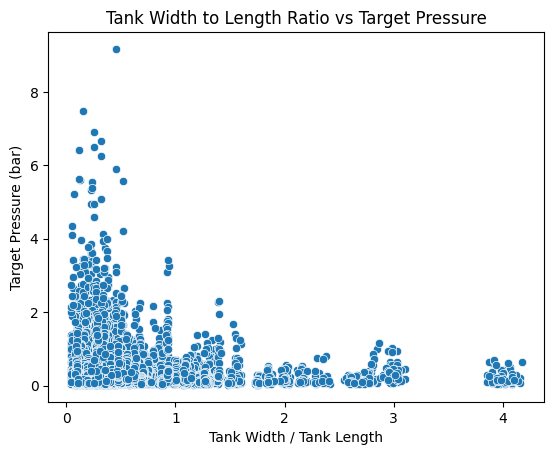

In [55]:
# Create a copy to avoid modifying the original DataFrame
train_copy = train.copy()

# Create the new feature in the copy
train_copy["TankWidthToLengthRatio"] = train_copy["Tank Width (m)"] / train_copy["Tank Length (m)"]

# Plotting the relationship between the ratio and the target
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x="TankWidthToLengthRatio", y="Target Pressure (bar)", data=train_copy)
plt.title("Tank Width to Length Ratio vs Target Pressure")
plt.xlabel("Tank Width / Tank Length")
plt.ylabel("Target Pressure (bar)")
plt.show()


This engineered feature captures the tank's aspect ratio, which may influence blast behavior.
Plotting it against the target variable to visually assess correlation or trends.
Feature engineering can improve models by capturing relationships missed by raw measurements.

# 2.0 Data Cleaning , Processing, Feature Engineering
The main goal here is to ensure clean data. <br>
I remove rows with missing values, outliers, and duplicates to improve data quality.

In [56]:
print("\nStarting Data Cleaning and Preprocessing...")

# Remove irrelevant features
# Drop ''Sensor Position Side' because:
# - 'Sensor Position Side' is redundant because (x, y, z) capture spatial information already
# - I don't drop other features, I've tried a lot and it just makes performance worse
train = train.drop(columns=["Sensor Position Side"])
test = test.drop(columns=["Sensor Position Side"])

print("\nMissing Values in Each Column:")
print(train.isnull().sum())

# Drop rows with missing values, clean data is important
train = train.dropna()

print("\nInitial Training Data Info:")
train.info()
print("\nInitial Test Data Info:")
test.info()

# Status in train dataset need to be fixed
print(train["Status"].unique())
print(test["Status"].unique())

# Features that will be binary encoded
print(train["Liquid Boiling Temperature (K)"].unique())
print(train["Liquid Critical Pressure (bar)"].unique())
print(train["Liquid Critical Temperature (K)"].unique())

print(test["Liquid Boiling Temperature (K)"].unique())
print(test["Liquid Critical Pressure (bar)"].unique())
print(test["Liquid Critical Temperature (K)"].unique())


Starting Data Cleaning and Preprocessing...

Missing Values in Each Column:
Unnamed: 0                          7
Tank Failure Pressure (bar)        10
Liquid Ratio                        9
Tank Width (m)                      7
Tank Length (m)                     5
Tank Height (m)                     8
BLEVE Height (m)                   10
Vapour Height (m)                   9
Vapour Temperature (K)             28
Liquid Temperature (K)             28
Obstacle Distance to BLEVE (m)      8
Obstacle Width (m)                  8
Obstacle Height (m)                 8
Obstacle Thickness (m)              8
Obstacle Angle                      8
Status                              8
Liquid Critical Pressure (bar)     28
Liquid Boiling Temperature (K)     27
Liquid Critical Temperature (K)    29
Sensor ID                           8
Sensor Position x                   7
Sensor Position y                   9
Sensor Position z                   7
Target Pressure (bar)               6
dtype: int6

# 2.1 Status Fix
misspelling issues

In [57]:
# ---------------------------------------------
# 1.  Build a normalised lookup table
# ---------------------------------------------
_status_lookup = {
    # anything that should become Superheated ↓
    "superheated" : "Superheated",
    "superheat"   : "Superheated",
    "saperheated" : "Superheated",

    # anything that should become Subcooled ↓
    "subcooled" : "Subcooled",
    "subcool"   : "Subcooled",
    "subcoled"  : "Subcooled",
}

# ---------------------------------------------
# 2.  Helper to clean one dataframe in-place
# ---------------------------------------------
def clean_status(df, col="Status"):
    """Normalise misspellings in the Status column."""
    df[col] = (
        df[col]
          .str.strip()        # remove leading/trailing spaces
          .str.lower()        # case-insensitive compare
          .map(_status_lookup)   # map to canonical label
    )
    return df

# ---------------------------------------------
# 3.  Apply to train (and optionally test)
# ---------------------------------------------
train = clean_status(train)      # <- in-place update
test  = clean_status(test)       # optional, but recommended

# Quick sanity check
print("Unique Status values in train:", train["Status"].unique())
print("Unique Status values in test :",  test["Status"].unique())

Unique Status values in train: ['Superheated' 'Subcooled']
Unique Status values in test : ['Subcooled' 'Superheated']


# 2.2 Drop Duplicates

In [58]:
print(f"\nTraining data shape before dropping duplicates: {train.shape}")
duplicates_before = train.duplicated().sum()
print(f"Number of duplicate rows in training data: {duplicates_before}")
train.drop_duplicates(inplace=True)
print(f"Training data shape after dropping duplicates: {train.shape}")


Training data shape before dropping duplicates: (9940, 24)
Number of duplicate rows in training data: 50
Training data shape after dropping duplicates: (9890, 24)


In [59]:
print(f"\nTraining data shape before dropping duplicates: {test.shape}")
duplicates_before = test.duplicated().sum()
print(f"Number of duplicate rows in test data: {duplicates_before}")


Training data shape before dropping duplicates: (3203, 23)
Number of duplicate rows in test data: 0


In [60]:
# Overview After Cleaning
print("\nCleaned training data info:")
train.info()


Cleaned training data info:
<class 'pandas.core.frame.DataFrame'>
Index: 9890 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       9890 non-null   float64
 1   Tank Failure Pressure (bar)      9890 non-null   float64
 2   Liquid Ratio                     9890 non-null   float64
 3   Tank Width (m)                   9890 non-null   float64
 4   Tank Length (m)                  9890 non-null   float64
 5   Tank Height (m)                  9890 non-null   float64
 6   BLEVE Height (m)                 9890 non-null   float64
 7   Vapour Height (m)                9890 non-null   float64
 8   Vapour Temperature (K)           9890 non-null   float64
 9   Liquid Temperature (K)           9890 non-null   float64
 10  Obstacle Distance to BLEVE (m)   9890 non-null   float64
 11  Obstacle Width (m)               9890 non-null   float64
 

# 2.3 Binary Mappings
Features like Status, Liquid Critical Pressure, Liquid Boiling Temperature, etc can be binary encoded because they had only 2 types of unique values.

In [61]:
# Define binary mappings
binary_mappings = {
    "Status": {"Subcooled": 0, "Superheated": 1},
    "Liquid Critical Pressure (bar)": {37.9: 0, 42.5: 1},
    "Liquid Boiling Temperature (K)": {-42.0: 0, -1.0: 1},
    "Liquid Critical Temperature (K)": {96.7: 0, 152.0: 1}
}

# Apply binary encoding to both train and test, and drop original columns
for col, mapping in binary_mappings.items():
    new_col = f"{col}_bin"
    train[new_col] = train[col].map(mapping)
    test[new_col] = test[col].map(mapping)

# Drop original columns
train.drop(columns=binary_mappings.keys(), inplace=True)
test.drop(columns=binary_mappings.keys(), inplace=True)

# 2.4 Obstacle Angle Conversion
Instead of keeping the angle between 1 and 30, I converted it to radians and then applied the sine to make this feature more meaningful.

In [62]:
print("Unique Status values in Obstacle Angle:", train["Obstacle Angle"].unique())

Unique Status values in Obstacle Angle: [ 1.  5. 17. 22. 27. 10. 30. 12. 25.  3. 15.  9.  8. 13.  6.  0. 29. 18.
  4.  2. 20. 16. 26. 23. 21. 11. 19. 28.  7. 14. 24.]


In [63]:
# Convert to radians and apply sine transformation
train["Obstacle Angle_sin"] = np.sin(np.radians(train["Obstacle Angle"]))
test["Obstacle Angle_sin"] = np.sin(np.radians(test["Obstacle Angle"]))

# Optional: drop the original angle column if no longer needed
train.drop(columns=["Obstacle Angle"], inplace=True)
test.drop(columns=["Obstacle Angle"], inplace=True)

# Check result - display the first 5 rows
print(train["Obstacle Angle_sin"].head())

0    0.017452
1    0.017452
2    0.017452
3    0.017452
4    0.017452
Name: Obstacle Angle_sin, dtype: float64


# 2.5 Correlations for each of the features

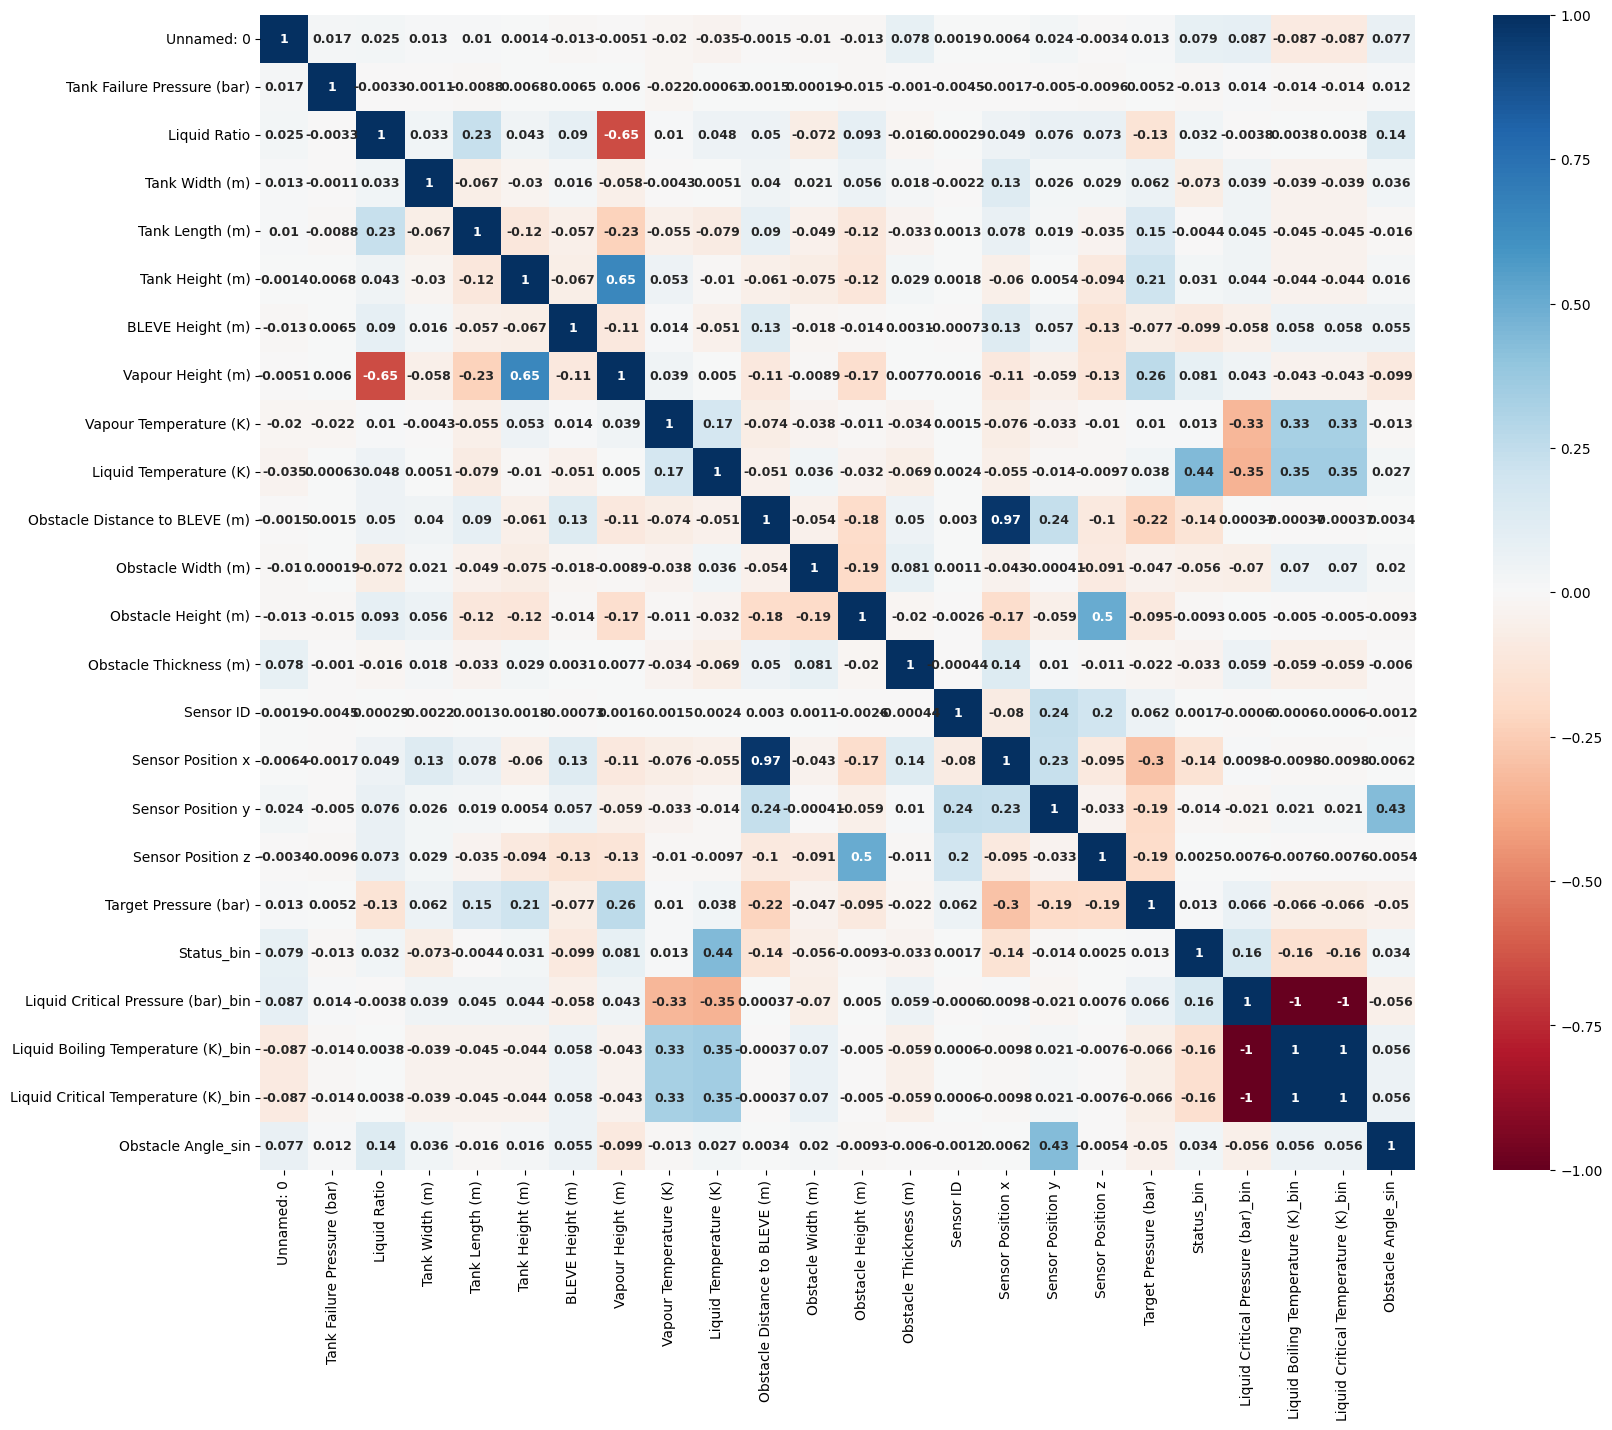

Target Pressure (bar)                  1.000000
Vapour Height (m)                      0.262291
Tank Height (m)                        0.207011
Tank Length (m)                        0.149822
Liquid Critical Pressure (bar)_bin     0.066134
Sensor ID                              0.062450
Tank Width (m)                         0.062206
Liquid Temperature (K)                 0.037858
Unnamed: 0                             0.013197
Status_bin                             0.013165
Vapour Temperature (K)                 0.010112
Tank Failure Pressure (bar)            0.005248
Obstacle Thickness (m)                -0.021664
Obstacle Width (m)                    -0.046779
Obstacle Angle_sin                    -0.049817
Liquid Boiling Temperature (K)_bin    -0.066134
Liquid Critical Temperature (K)_bin   -0.066134
BLEVE Height (m)                      -0.077155
Obstacle Height (m)                   -0.095181
Liquid Ratio                          -0.134825
Sensor Position z                     -0

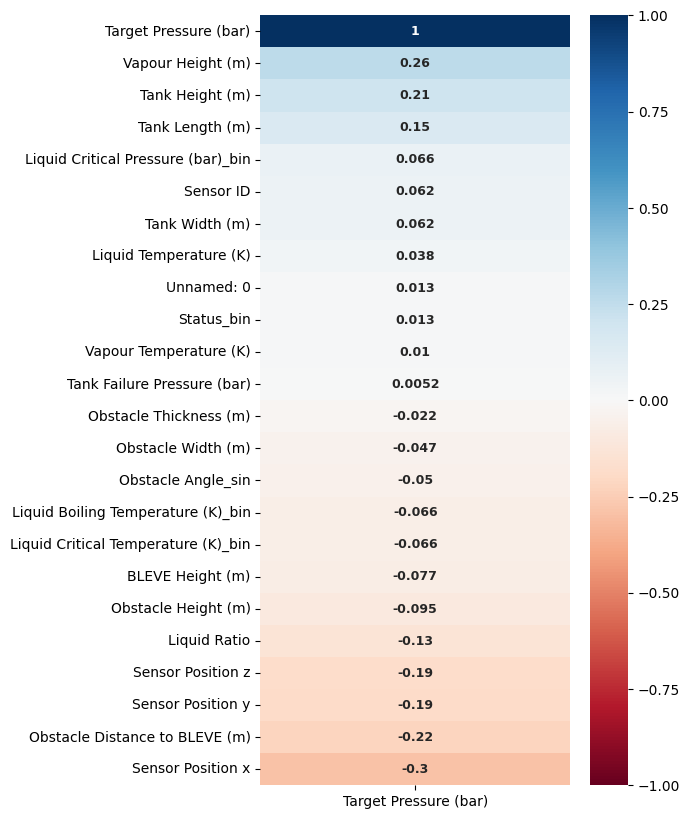

In [64]:
# correlation values for each of the features
corr = train.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True,
            annot_kws={'fontsize':9, 'fontweight':'bold'})

plt.show()

# Get correlation of 'Target Pressure' with all other features
target_corr = corr["Target Pressure (bar)"].sort_values(ascending=False)  # Sort for better readability

# Display the correlation values
print(target_corr)

plt.figure(figsize=(5, 10))  # Adjust the figure size as needed
sns.heatmap(target_corr.to_frame(), annot=True, cmap='RdBu', vmin=-1, vmax=1, square=False,
            annot_kws={'fontsize':9, 'fontweight':'bold'})

plt.show()



High positive or high negative correlations with the target variable are good candidates for model features. Also helps detect multicollinearity between input features (important for linear models).

Features strongly correlated with Target Pressure -> keep them.

# 2.6  Feature Engineering
Commented out, NN model performance gets worse.

In [65]:
'''
# Create Tank Volume feature
train["Tank Volume"] = (
    train["Tank Width (m)"] * train["Tank Length (m)"] * train["Tank Height (m)"]
)
test["Tank Volume"] = (
    test["Tank Width (m)"] * test["Tank Length (m)"] * test["Tank Height (m)"]
)


# Drop the original tank dimension columns
tank_dim_cols = ["Tank Width (m)", "Tank Length (m)", "Tank Height (m)"]
train.drop(columns=tank_dim_cols, inplace=True)
test.drop(columns=tank_dim_cols, inplace=True)

# Sanity check
print(train[["Tank Volume"]].head())

print("\nAfter Feature Engineering Tank Volume training data info:")
train.info()


# Create Sensor Distance (3D Euclidean distance from origin)
train["Sensor Distance"] = np.sqrt(
    train["Sensor Position x"]**2 +
    train["Sensor Position y"]**2 +
    train["Sensor Position z"]**2
)

test["Sensor Distance"] = np.sqrt(
    test["Sensor Position x"]**2 +
    test["Sensor Position y"]**2 +
    test["Sensor Position z"]**2
)

# Drop the original sensor coordinate columns
sensor_cols = ["Sensor Position x", "Sensor Position y", "Sensor Position z"]
train.drop(columns=sensor_cols, inplace=True)
test.drop(columns=sensor_cols, inplace=True)

# Confirm new feature
print(train[["Sensor Distance"]].head())

print("\nAfter Feature Engineering Sensor Distance training data info:")
train.info()
test.info()

'''



'\n# Create Tank Volume feature\ntrain["Tank Volume"] = (\n    train["Tank Width (m)"] * train["Tank Length (m)"] * train["Tank Height (m)"]\n)\ntest["Tank Volume"] = (\n    test["Tank Width (m)"] * test["Tank Length (m)"] * test["Tank Height (m)"]\n)\n\n\n# Drop the original tank dimension columns\ntank_dim_cols = ["Tank Width (m)", "Tank Length (m)", "Tank Height (m)"]\ntrain.drop(columns=tank_dim_cols, inplace=True)\ntest.drop(columns=tank_dim_cols, inplace=True)\n\n# Sanity check\nprint(train[["Tank Volume"]].head())\n\nprint("\nAfter Feature Engineering Tank Volume training data info:")\ntrain.info()\n\n\n# Create Sensor Distance (3D Euclidean distance from origin)\ntrain["Sensor Distance"] = np.sqrt(\n    train["Sensor Position x"]**2 +\n    train["Sensor Position y"]**2 +\n    train["Sensor Position z"]**2\n)\n\ntest["Sensor Distance"] = np.sqrt(\n    test["Sensor Position x"]**2 +\n    test["Sensor Position y"]**2 +\n    test["Sensor Position z"]**2\n)\n\n# Drop the original se

# 4.0 Model Selection
I will choose XGBoost, linear regression, and MLP neural network to acomplish assignment specification, at least 3 different models.

# 4.1 XGBoost with 5-Fold Cross-Validation

In [66]:
# ------------------------------------------
# Model Development - XGBoost with 5-Fold Cross-Validation
# ------------------------------------------

print("\nStarting Phase 3: Model Development (XGBoost)...")

# Create a copy of the cleaned training data
train_data = train.copy()
test_data = test.copy()

# 1. Separate Features and Target
X = train_data.drop(columns=["Target Pressure (bar)"])
y = train_data["Target Pressure (bar)"]

# 2. 5-Fold Cross Validation Setup
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mape_scores = []
r2_scores = []

fold = 1

for train_index, val_index in kf.split(X):
    print(f"\n--- Fold {fold} ---")

    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # 3. Build and Train XGBoost Model
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_fold, y_train_fold)

    # 4. Evaluate Model
    y_val_pred = model.predict(X_val_fold)

    mape = mean_absolute_percentage_error(y_val_fold, y_val_pred)
    r2 = r2_score(y_val_fold, y_val_pred)

    print(f"MAPE: {mape:.4f}")
    print(f"R²: {r2:.2%}")

    mape_scores.append(mape)
    r2_scores.append(r2)

    fold += 1

# 5. Cross-Validation Summary
print("\n=== Cross-Validation Results (XGBoost) ===")
print(f"Average MAPE: {np.mean(mape_scores):.4f}")
print(f"Average R²: {np.mean(r2_scores):.2%}")

# 6. Train Final Model on Full Dataset
final_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X, y)

# 7. Predict on Test Set
X_test_final = test_data.copy()
y_test_pred = final_model.predict(X_test_final)

# 8. Create Submission File
submission = pd.DataFrame({
    "ID": test.index,
    "Target Pressure (bar)": y_test_pred
})

submission.to_csv("submission_xgb.csv", index=False)
print("\nSaved XGBoost predictions to 'submission_xgb.csv'! Ready to upload to Kaggle.")



Starting Phase 3: Model Development (XGBoost)...

--- Fold 1 ---
MAPE: 0.1785
R²: 93.35%

--- Fold 2 ---
MAPE: 0.1705
R²: 93.95%

--- Fold 3 ---
MAPE: 0.1754
R²: 88.26%

--- Fold 4 ---
MAPE: 0.1817
R²: 94.60%

--- Fold 5 ---
MAPE: 0.1761
R²: 93.71%

=== Cross-Validation Results (XGBoost) ===
Average MAPE: 0.1764
Average R²: 92.77%

Saved XGBoost predictions to 'submission_xgb.csv'! Ready to upload to Kaggle.


I know that hyperparameter tuning for XGBoost, along with feature engineering and ensembling, might enhance the model's accuracy. However, I have decided to proceed with the neural network instead.

# 4.2 Linear Regression

In [67]:
# ------------------------------------------
# Model Development - Linear Regression
# ------------------------------------------

from sklearn.linear_model import LinearRegression


print("\nStarting Phase: Model Development (Linear Regression)...")

# 1. Separate Features and Target
X = train.drop(columns=["Target Pressure (bar)"])  # Input features
y = train["Target Pressure (bar)"]                 # Target variable

# 2. Train-Test Split (optional, not needed if not validating)
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Build and Train Linear Regression Model
lin_model = LinearRegression()
lin_model.fit(X, y)

print("Linear Regression model trained.")

# 4. Evaluate on Training Data
y_train_pred = lin_model.predict(X)

train_mape = mean_absolute_percentage_error(y, y_train_pred)
train_r2 = r2_score(y, y_train_pred)

print(f"\nLinear Regression Performance on Training Data:")
print(f"  MAPE: {train_mape:.4f}")
print(f"  R² Score: {train_r2:.2%}")

# 5. Predict on Test Set
X_test = test.copy()
y_test_pred = lin_model.predict(X_test)

# Ensure predictions are non-negative
y_test_pred = np.maximum(0, y_test_pred)

# 6. Create Submission File
submission = pd.DataFrame({
    "ID": test.index,
    "Target Pressure (bar)": y_test_pred
})

submission.to_csv("submission_linreg.csv", index=False)

print("\nSaved Linear Regression predictions to 'submission_linreg.csv'! Ready to upload to Kaggle.")



Starting Phase: Model Development (Linear Regression)...
Linear Regression model trained.

Linear Regression Performance on Training Data:
  MAPE: 1.2946
  R² Score: 44.01%

Saved Linear Regression predictions to 'submission_linreg.csv'! Ready to upload to Kaggle.


# 4.3 Neural Network
Hyperparameter tuning with Optuna
The results vary every time I run the code,
but the best score was:
- Best CV MAPE achieved (on original scale): 18.0873
- Best Hyperparameters found:
- n_layers: 4
- learning_rate: 0.0009943605597109975
- optimizer: adam
- dropout_rate: 0.24304060743917955
- batch_size: 256
- n_units_l0: 231
- activation_l0: swish
- n_units_l1: 362
- activation_l1: tanh
- n_units_l2: 277
- activation_l2: relu
- n_units_l3: 132
- activation_l3: tanh
- Epoch 497/500
- Final Model Performance on Training Data:
- Loss (MAE on original target): 0.0251
- MAE (on original target): 0.0251
- MAPE (on original scale): 9.110122
- R2 Score (on original scale): 98.04%

The data was preprocessed through cleaning and encoding, followed by the application of StandardScaler to optimize its utilization in the neural network.

In [68]:
# --- Separate X/y and Apply StandardScaler to Features (Target remains unscaled) ---
print("\n--- Separating X/y and Applying StandardScaler to Features ---")

# Separate features (X) and target (y) in the training data
target_col = 'Target Pressure (bar)'
if target_col in train.columns:
    X = train.drop(columns=[target_col])
    y = train[target_col].copy() # Use original y (unscaled)
    print(f"Separated target '{target_col}' from training features. Target is NOT scaled.")
else:
    print(f"Error: Target column '{target_col}' not found in training data. Cannot proceed with modeling.")
    X = None # Set X to None to indicate error
    y = None

# Identify numerical columns for feature scaling (all columns in X are now numerical or binary)
if X is not None:
    # Select all columns in X for scaling, including the binary encoded ones
    features_to_scale = X.columns.tolist()
    print(f"Features to scale: {features_to_scale}")

    # Initialize the scaler for features
    feature_scaler = StandardScaler()

    # Fit on training features and transform training features
    X_scaled = feature_scaler.fit_transform(X[features_to_scale])
    X_scaled = pd.DataFrame(X_scaled, columns=features_to_scale, index=X.index) # Convert back to DataFrame

    print("Training features scaled.")
    print("Scaled training features head:")
    print(X_scaled.head())

    # Transform test features using the SAME fitted feature_scaler
    # Ensure test set has the same columns in the same order as the training features *before* scaling
    # Select only the columns that were scaled in training
    test_features_for_scaling = test[features_to_scale].copy()

    # Handle potential NaNs in test features before scaling (e.g., if new NaNs were introduced unexpectedly)
    if test_features_for_scaling.isnull().any().any():
        print("Warning: NaNs detected in test features before scaling. Imputing with training mean/mode.")
        for col in test_features_for_scaling.columns:
             if test_features_for_scaling[col].isnull().any():
                 # Use the mean/mode from the original training features (X) for imputation in test
                 if col in X.columns:
                    # For binary columns, use mode; for others, use mean
                    if np.all(np.isin(X[col].dropna().unique(), [0, 1])): # Check if it's a binary column
                         train_fill_value = X[col].mode()[0]
                         print(f"Imputing NaNs in test column '{col}' with training mode: {train_fill_value}")
                    else:
                         train_fill_value = X[col].mean()
                         print(f"Imputing NaNs in test column '{col}' with training mean: {train_fill_value}")
                    test_features_for_scaling[col] = test_features_for_scaling[col].fillna(train_fill_value)
                 else:
                    # Fallback if cannot find in original X (shouldn't happen if logic is correct)
                    test_features_for_scaling[col] = test_features_for_scaling[col].fillna(0) # Simple fallback imputation
                    print(f"Warning: Could not find column '{col}' in original training features for imputation. Filling test NaNs with 0.")


    test_scaled = feature_scaler.transform(test_features_for_scaling)
    test_scaled = pd.DataFrame(test_scaled, columns=features_to_scale, index=test_features_for_scaling.index) # Convert back to DataFrame

    print("Test features scaled.")
    print("Scaled test features head:")
    print(test_scaled.head())

    # Target is NOT scaled in this approach
    print("\nFeature Scaling Complete. Target remains unscaled.")
    print(f"Scaled Training Features shape: {X_scaled.shape}")
    print(f"Training Target shape: {y.shape}") # Shape of original y
    print(f"Scaled Test Features shape: {test_scaled.shape}")

else:
    print("Skipping scaling and subsequent steps due to missing target column.")


# --- MODIFIED CODE: Hyperparameter Tuning with Optuna ---
# The objective function will now train/validate and evaluate directly on the original target scale.
if X is not None:
    print("\n--- Starting Hyperparameter Tuning with Optuna ---")

    # Define evaluation metrics functions (using sklearn)
    # These functions will now work directly on the original scale predictions and true values
    def calculate_mape(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        non_zero_mask = y_true != 0
        if np.sum(non_zero_mask) == 0:
            return np.inf # Handle case with no non-zero true values
        # Add small epsilon to denominator to avoid division by zero issues with very small true values
        epsilon = 1e-8
        return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / (y_true[non_zero_mask] + epsilon))) * 100

    def calculate_r2(y_true, y_pred):
        return r2_score(y_true, y_pred)

    # Define the objective function for Optuna for hyperparameter optimization
    # Model will train and predict on the *original* target scale
    def objective(trial):
        # Hyperparameters to tune
        n_layers = trial.suggest_int('n_layers', 2, 5) # Number of hidden layers
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3, log=True)
        optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.4)
        batch_size = trial.suggest_categorical('batch_size', [128, 256])

        # Build the Keras model
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_scaled.shape[1],))) # Input layer size based on number of features

        for i in range(n_layers):
            # Units in each dense layer
            units = trial.suggest_int(f'n_units_l{i}', 64, 512, log=True)
            activation = trial.suggest_categorical(f'activation_l{i}', ['relu', 'tanh', 'swish'])
            model.add(layers.Dense(units, activation=activation))
            model.add(layers.BatchNormalization()) # Batch Normalization often helps
            model.add(layers.Dropout(dropout_rate))

        model.add(layers.Dense(1)) # Output layer predicts the *original* target

        # Select optimizer
        if optimizer_name == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_name == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        # Add other optimizers if desired (e.g., SGD, AdamW)

        # Compile the model - Use Mean Absolute Error (MAE) as the loss function on the *original* target
        model.compile(optimizer=optimizer, loss='mae', metrics=['mae']) # Monitor MAE during training

        # Cross-validation setup for robust evaluation during tuning
        n_splits = 5 # Number of folds
        # Use X_scaled and original y for splitting and training/validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_mape_scores = [] # To store MAPE scores from each fold on ORIGINAL scale

        # Loop through each fold
        for fold, (train_index, val_index) in enumerate(kf.split(X_scaled, y)): # Split based on X_scaled and original y
            X_train_fold, X_val_fold = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index] # Use original y for training/validation loss and evaluation

            # Clear session and reset model weights for each fold to ensure independence
            tf.keras.backend.clear_session()
            # Re-build model structure within the loop for a clean state
            fold_model = keras.Sequential()
            fold_model.add(layers.Input(shape=(X_scaled.shape[1],)))
            for i in range(n_layers):
                 units = trial.params[f'n_units_l{i}'] # Use params from trial
                 activation = trial.params[f'activation_l{i}']
                 fold_model.add(layers.Dense(units, activation=activation))
                 fold_model.add(layers.BatchNormalization())
                 fold_model.add(layers.Dropout(dropout_rate))
            fold_model.add(layers.Dense(1))

            # Re-compile with the same optimizer settings
            if optimizer_name == 'adam': opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            elif optimizer_name == 'rmsprop': opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
            fold_model.compile(optimizer=opt, loss='mae', metrics=['mae'])


            # Early stopping callback to prevent overfitting during training within each fold
            # Monitor validation loss on the *original* target
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # Monitor validation loss on original target
                                                              patience=20, # Number of epochs with no improvement
                                                              restore_best_weights=True,
                                                              verbose=0)

            # Train the model for the current fold using scaled features and original target
            history = fold_model.fit(X_train_fold, y_train_fold, # Train on original target
                                     epochs=500, # Maximum number of epochs
                                     batch_size=batch_size,
                                     validation_data=(X_val_fold, y_val_fold), # Validate on original target
                                     callbacks=[early_stopping],
                                     verbose=0)

            # Evaluate on the validation fold using the best weights restored by early stopping
            # Predict on the original target scale
            y_pred_fold = fold_model.predict(X_val_fold).flatten()

            # Calculate MAPE for this fold on the ORIGINAL scale
            mape_fold = calculate_mape(y_val_fold, y_pred_fold)
            cv_mape_scores.append(mape_fold)

            # Optuna Pruning: Report intermediate validation loss (on original target)
            early_stopping_metric = 'val_loss' # Ensure this matches the monitor in EarlyStopping
            if early_stopping_metric in history.history:
                 best_epoch_index = np.argmin(history.history[early_stopping_metric])
                 intermediate_value = history.history[early_stopping_metric][best_epoch_index]
                 trial.report(intermediate_value, step=fold)
                 if trial.should_prune():
                      print(f"Trial {trial.number} pruned at fold {fold}.")
                      raise optuna.exceptions.TrialPruned()
            else:
                 print(f"Warning: Metric \'{early_stopping_metric}\' not found in history for pruning.")


        # Calculate average MAPE across all folds on the ORIGINAL scale
        avg_mape = np.mean(cv_mape_scores)

        # Handle cases where MAPE calculation might fail
        if np.isnan(avg_mape) or np.isinf(avg_mape):
            print(f"Trial {trial.number}: Invalid Avg MAPE computed ({avg_mape}). Assigning high value for minimization.")
            return float('inf')

        print(f"Trial {trial.number}: Avg MAPE={avg_mape:.6f}")

        # Optuna aims to minimize the objective function. Minimize MAPE on original scale.
        return avg_mape

    # Create and run the Optuna study
    print("\n--- Starting Optuna Hyperparameter Tuning ---")
    study = optuna.create_study(direction='minimize',
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5, n_min_trials=10))

    # Run the optimization. Using increased trials and timeout as per previous attempt.
    study.optimize(objective, n_trials=100, timeout=1200) # Increased trials/timeout

    # Get the best trial results
    best_trial = study.best_trial
    best_hyperparameters = best_trial.params
    best_mape = best_trial.value # This is MAPE on original scale

    print("\n--- Hyperparameter Tuning Complete ---")
    print(f"Best CV MAPE achieved (on original scale): {best_mape:.4f}")
    print("Best Hyperparameters found:")
    for key, value in best_hyperparameters.items():
        print(f"  {key}: {value}")


    # --- Final Model Training ---
    # Train the final model on the ENTIRE scaled training dataset (X_scaled) and original target (y)
    print("\n--- Training Final Model with Best Hyperparameters ---")

    # Clear session before building the final model
    tf.keras.backend.clear_session()

    # Build the final model using the best hyperparameters found by Optuna
    final_model = keras.Sequential()
    final_model.add(layers.Input(shape=(X_scaled.shape[1],))) # Input layer size matches scaled features

    # Add hidden layers with the best number of layers, units, and activation
    for i in range(best_hyperparameters['n_layers']):
        units = best_hyperparameters[f'n_units_l{i}']
        activation = best_hyperparameters[f'activation_l{i}']
        final_model.add(layers.Dense(units, activation=activation))
        final_model.add(layers.BatchNormalization()) # Include Batch Normalization
        final_model.add(layers.Dropout(best_hyperparameters['dropout_rate'])) # Include Dropout

    final_model.add(layers.Dense(1)) # Output layer predicts the *original* target

    # Compile the final model with the best optimizer and learning rate
    optimizer_name = best_hyperparameters['optimizer']
    learning_rate = best_hyperparameters['learning_rate']
    if optimizer_name == 'adam':
        final_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        final_optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    # Add other optimizers if used in tuning

    # Compile model - Train on original target using MAE loss
    final_model.compile(optimizer=final_optimizer, loss='mae', metrics=['mae'])

    # Train the final model on the ENTIRE scaled training dataset (X_scaled) and original target (y)
    # Use early stopping again, monitoring the training loss on the original target
    final_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', # Monitor training loss on original target
                                                            patience=30, # Increased patience for full training
                                                            restore_best_weights=True,
                                                            verbose=1) # Show training progress

    print("Starting final model training (predicting original target)...")
    history_final = final_model.fit(X_scaled, y, # Train on original target
                                    epochs=500, # Maximum epochs for final training
                                    batch_size=best_hyperparameters['batch_size'],
                                    verbose=1, # Show training progress
                                    callbacks=[final_early_stopping]
                                    )

    print("\nFinal Model Training Complete.")
    final_model.summary()

    # Evaluate the final model on the training data itself (optional sanity check)
    # Evaluate on the original scale since the model predicts on that scale
    print(f"\nFinal Model Performance on Training Data:")
    # Keras evaluate on original data
    loss, mae = final_model.evaluate(X_scaled, y, verbose=0) # Evaluate using original y
    print(f"  Loss (MAE on original target): {loss:.4f}")
    print(f"  MAE (on original target): {mae:.4f}")

    # Predict on scaled training data for R2 and MAPE calculation
    y_pred_train = final_model.predict(X_scaled).flatten()
    train_mape = calculate_mape(y, y_pred_train) # Use original y for evaluation
    train_r2 = calculate_r2(y, y_pred_train) # Use original y for evaluation

    print(f"  MAPE (on original scale): {train_mape:.6f}")
    print(f"  R2 Score (on original scale): {train_r2:.2%}")


    # --- Prediction Generation ---
    print("\n--- Generating Predictions for Test Data ---")

    # Ensure test data is scaled correctly (already done as test_scaled)
    print(f"Shape of scaled test data for prediction: {test_scaled.shape}")

    # Generate predictions on the scaled test data (these are directly on the original target scale)
    test_predictions = final_model.predict(test_scaled).flatten()

    print(f"Number of predictions generated (original scale): {len(test_predictions)}")

    # It's good practice to ensure predictions for physical quantities like pressure are non-negative
    test_predictions = np.maximum(0, test_predictions)
    print("Sample Final Predictions (Original Scale, after ensuring non-negative):")
    print(test_predictions[:10])

    # Create the submission file in the specified Kaggle format
    # The 'ID' column should correspond to the original index of the test set.
    # Since we dropped columns but not rows from the original test_df_raw for the test_df_processed/test_scaled,
    # the index of test_scaled should correspond to the original row indices (0 to 3202).

    submission_df = pd.DataFrame({
        'ID': test_scaled.index, # Use the index of the scaled test DataFrame for IDs
        'Target Pressure (bar)': test_predictions # Use the predictions directly (they are on the original scale)
        })

    print("\nSubmission DataFrame Head:")
    print(submission_df.head())
    print("\nSubmission DataFrame Tail:")
    print(submission_df.tail())

    # Save the submission file
    submission_filename = "prediction.csv"
    submission_df.to_csv(submission_filename, index=False)
    print(f"\nPredictions saved to {submission_filename}")
    print("\n--- Notebook Execution Complete ---")

else:
    print("Model training, tuning, and prediction skipped due to errors in previous steps (e.g., missing target).")


[I 2025-05-04 12:21:42,967] A new study created in memory with name: no-name-236d49eb-6aeb-43f2-827e-c8da72db706a



--- Separating X/y and Applying StandardScaler to Features ---
Separated target 'Target Pressure (bar)' from training features. Target is NOT scaled.
Features to scale: ['Unnamed: 0', 'Tank Failure Pressure (bar)', 'Liquid Ratio', 'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)', 'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)', 'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)', 'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)', 'Sensor ID', 'Sensor Position x', 'Sensor Position y', 'Sensor Position z', 'Status_bin', 'Liquid Critical Pressure (bar)_bin', 'Liquid Boiling Temperature (K)_bin', 'Liquid Critical Temperature (K)_bin', 'Obstacle Angle_sin']
Training features scaled.
Scaled training features head:
   Unnamed: 0  Tank Failure Pressure (bar)  Liquid Ratio  Tank Width (m)  \
0   -1.730590                    -0.101285     -1.076507       -0.190450   
1   -1.730244                    -0.101809     -1.076507       -0.177345   
2 

[I 2025-05-04 12:31:50,086] Trial 0 finished with value: 19.25641562252061 and parameters: {'n_layers': 5, 'learning_rate': 0.0026387046911400783, 'optimizer': 'rmsprop', 'dropout_rate': 0.38051478663468313, 'batch_size': 256, 'n_units_l0': 495, 'activation_l0': 'swish', 'n_units_l1': 129, 'activation_l1': 'relu', 'n_units_l2': 78, 'activation_l2': 'swish', 'n_units_l3': 65, 'activation_l3': 'tanh', 'n_units_l4': 219, 'activation_l4': 'relu'}. Best is trial 0 with value: 19.25641562252061.


Trial 0: Avg MAPE=19.256416
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-04 12:38:17,485] Trial 1 finished with value: 17.62533878115992 and parameters: {'n_layers': 2, 'learning_rate': 0.003066215288448807, 'optimizer': 'rmsprop', 'dropout_rate': 0.25216959549846407, 'batch_size': 256, 'n_units_l0': 89, 'activation_l0': 'relu', 'n_units_l1': 501, 'activation_l1': 'tanh'}. Best is trial 1 with value: 17.62533878115992.


Trial 1: Avg MAPE=17.625339
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2025-05-04 13:12:42,181] Trial 2 finished with value: 14.348948489195402 and parameters: {'n_layers': 5, 'learning_rate': 0.00021158528878371843, 'optimizer': 'adam', 'dropout_rate': 0.11554174915375351, 'batch_size': 256, 'n_units_l0': 190, 'activation_l0': 'swish', 'n_units_l1': 97, 'activation_l1': 'relu', 'n_units_l2': 279, 'activation_l2': 'tanh', 'n_units_l3': 262, 'activation_l3': 'swish', 'n_units_l4': 139, 'activation_l4': 'relu'}. Best is trial 2 with value: 14.348948489195402.


Trial 2: Avg MAPE=14.348948

--- Hyperparameter Tuning Complete ---
Best CV MAPE achieved (on original scale): 14.3489
Best Hyperparameters found:
  n_layers: 5
  learning_rate: 0.00021158528878371843
  optimizer: adam
  dropout_rate: 0.11554174915375351
  batch_size: 256
  n_units_l0: 190
  activation_l0: swish
  n_units_l1: 97
  activation_l1: relu
  n_units_l2: 279
  activation_l2: tanh
  n_units_l3: 262
  activation_l3: swish
  n_units_l4: 139
  activation_l4: relu

--- Training Final Model with Best Hyperparameters ---
Starting final model training (predicting original target)...
Epoch 1/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.9778 - mae: 0.9778
Epoch 2/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.7528 - mae: 0.7528
Epoch 3/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.6458 - mae: 0.6458
Epoch 4/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5978 - mae: 0.5978
Epoch 5/500
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5480 - mae: 0.5480
Epo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 190)            │         4,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 190)            │           760 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 190)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 97)             │        18,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97)             │           388 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 97)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 279)            │        27,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 279)            │         1,116 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 279)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 262)            │        73,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 262)            │         1,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 262)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 139)            │        36,557 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 139)            │           556 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 139)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,196 (1.87 MB)

 Trainable params: 162,420 (634.45 KB)

 Non-trainable params: 1,934 (7.55 KB)

 Optimizer params: 324,842 (1.24 MB)


Final Model Performance on Training Data:
  Loss (MAE on original target): 0.0297
  MAE (on original target): 0.0297
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
  MAPE (on original scale): 10.214641
  R2 Score (on original scale): 97.31%

--- Generating Predictions for Test Data ---
Shape of scaled test data for prediction: (3203, 23)
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Number of predictions generated (original scale): 3203
Sample Final Predictions (Original Scale, after ensuring non-negative):
[0.09608756 0.095535   0.09244634 0.07022978 0.06612535 0.06769215
 0.06548147 0.06084816 0.05588616 0.7818008 ]

Submission DataFrame Head:
   ID  Target Pressure (bar)
0   0               0.096088
1   1               0.095535
2   2               0.092446
3   3               0.070230
4   4               0.066125

Submission DataFrame Tail:
        ID  Target Pressure (bar)
3198  3198               0.797995
3199  3199               0.767034
3200  3200               0.732237
3201  3201        